In [1]:
import sys
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
sys.path.append('..')

from src.document_preprocessor import RegexTokenizer
from src.indexing import BasicInvertedIndex, Indexer, IndexType
from src.ranker import BM25, Ranker
from src.relevance import run_relevance_tests

from sentence_transformers import SentenceTransformer

/Users/aryan/Desktop/Umich/Terms/F24/SI650/Project/satire-news-search-engine/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
STOPWORD_PATH = '../data/stopwords_updated.txt'
DATASET_PATH = '../data/processed_articles_dedup.csv'
INDEX_PATH = '../data/index'

In [3]:
# Load in the stopwords

stopwords = set()
with open(STOPWORD_PATH, 'r', encoding='utf-8') as file:
    for stopword in file:
        stopwords.add(stopword.strip())
f'Stopwords collected {len(stopwords)}'

'Stopwords collected 550'

In [4]:
preprocessor = RegexTokenizer("\w+(?:-\w+)*(?:'[^stmrvld]\w*)*", lowercase=True)

# index = Indexer.create_index(
#     index_type=IndexType.BasicInvertedIndex,
#     dataset_path=DATASET_PATH,
#     document_preprocessor=preprocessor,
#     stopwords=stopwords,
#     minimum_word_frequency=1,
#     text_key='body',
#     id_key='docid',
#     max_docs=35292
# )

# index.save(INDEX_PATH)

In [5]:
index = BasicInvertedIndex()

index.load(INDEX_PATH)

In [6]:
bm25_scorer = BM25(index)
bm25_ranker = Ranker(index, preprocessor, stopwords, bm25_scorer)

In [7]:
metrics_bm25 = run_relevance_tests("../data/relevance_test.csv", ranker=bm25_ranker)

## BERT Interpolation on BM25

In [10]:
# Load the model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

class HybridRanker:
    def __init__(self, base_ranker: Ranker, raw_text_dict: dict, alpha: float = 0.5, rerank_top_k: int = 10):
        self.base_ranker = base_ranker
        self.raw_text_dict = raw_text_dict
        self.alpha = alpha
        self.rerank_top_k = rerank_top_k
        self.model = model  # Use the loaded model

    def query(self, query: str) -> list[tuple[int, float]]:
        # Get initial BM25 rankings
        bm25_results = self.base_ranker.query(query)

        # Only rerank top k documents
        top_k_results = bm25_results[:self.rerank_top_k]

        # Get query embedding
        query_embedding = self.model.encode(query)

        # Calculate BERT scores for top k
        reranked_scores = []
        docs = [self.raw_text_dict[docid] for docid, _ in top_k_results]
        doc_embeddings = self.model.encode(docs)

        # Calculate similarities
        for i, (docid, bm25_score) in enumerate(top_k_results):
            # Compute cosine similarity
            bert_score = float(doc_embeddings[i] @ query_embedding)

            # Combine scores using alpha
            final_score = self.alpha * bm25_score + (1 - self.alpha) * bert_score
            reranked_scores.append((docid, final_score))

        # Sort by combined score
        reranked_scores.sort(key=lambda x: x[1], reverse=True)

        return reranked_scores + bm25_results[self.rerank_top_k:]

# Load raw text for documents
raw_text_dict = {}
with open(DATASET_PATH, 'r', encoding='utf-8') as f:
    reader = csv.DictReader(f)
    for row in reader:
        raw_text_dict[int(row['docid'])] = row['body']

# Create hybrid ranker
hybrid_ranker = HybridRanker(
    base_ranker=bm25_ranker,
    raw_text_dict=raw_text_dict,
    alpha=0.3,
    rerank_top_k=10
)

# Run evaluation
metrics_hybrid = run_relevance_tests("../data/relevance_test.csv", ranker=hybrid_ranker)

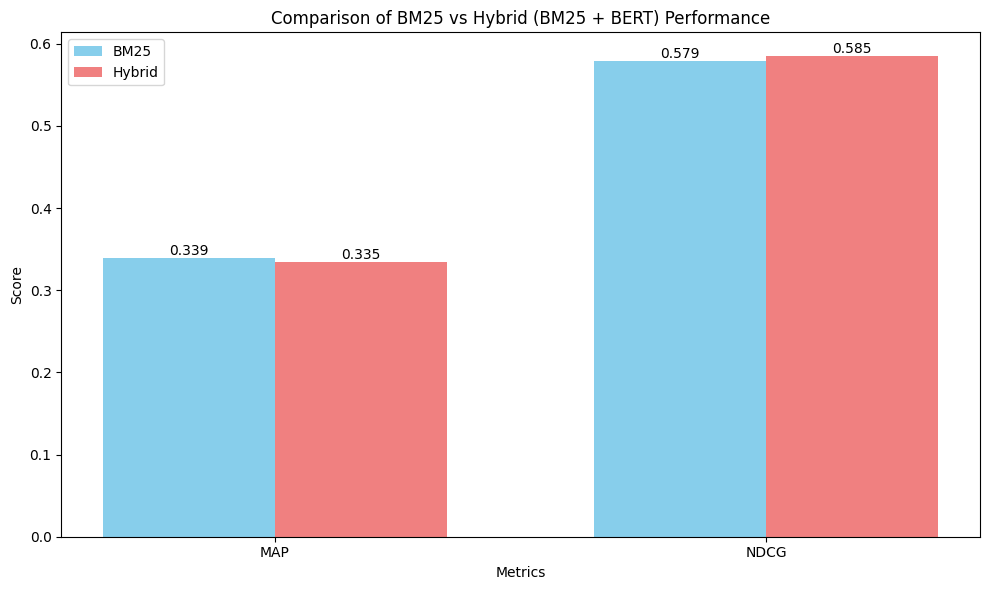

In [11]:
# Convert only the main metrics (excluding the lists)
metrics_dict = {
    'BM25': {'MAP': metrics_bm25['map'], 'NDCG': metrics_bm25['ndcg']},
    'Hybrid': {'MAP': metrics_hybrid['map'], 'NDCG': metrics_hybrid['ndcg']}
}

# Create DataFrame
metrics_df = pd.DataFrame(metrics_dict).T

# Create the visualization
plt.figure(figsize=(10, 6))
bar_width = 0.35
x = np.arange(len(metrics_df.columns))

plt.bar(x - bar_width/2, metrics_df.iloc[0], bar_width, label='BM25', color='skyblue')
plt.bar(x + bar_width/2, metrics_df.iloc[1], bar_width, label='Hybrid', color='lightcoral')

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Comparison of BM25 vs Hybrid (BM25 + BERT) Performance')
plt.xticks(x, metrics_df.columns)
plt.legend()

# Add value labels
for i in x:
    plt.text(i - bar_width/2, metrics_df.iloc[0,i], f'{float(metrics_df.iloc[0,i]):.3f}',
             ha='center', va='bottom')
    plt.text(i + bar_width/2, metrics_df.iloc[1,i], f'{float(metrics_df.iloc[1,i]):.3f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()